# Introduction

The objective of this notebook is to study the correlations between the independent features in order to use that correlations to impute missing values for the columns instead of blindly impute missing values with mean, median or other kind of imputation techniques.

More specifically, I'll be inspecting the following features:
- HomePlanet
- CryoSleep
- Cabin
- Destination
- VIP
- Age

The idea is to see how these features interact with the others and see if it will make sense to use the information available from other features to impute missing values.

Also, I will dedicate some part to analyse the outliers present in the numerical variables and how they interact with the objective variable.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from phik import phik_matrix
import missingno as msno
import scipy.stats as stats

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df['is_train'] = 1
test_df['is_train'] = 0
test_df['Transported'] = np.nan

full_df = pd.concat([train_df, test_df], ignore_index=True)

In [4]:
full_df.tail()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,is_train
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,0
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,0
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,0
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,0
12969,9277_01,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,NaN,0


# Missing values

Let's check the number of missing values by column:

In [5]:
full_df.isnull().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
is_train           0
dtype: int64

Let's see if the missing values respond to any pattern with `missingno`. This library helps us identify if missing values tend to occur together in two or more variables:

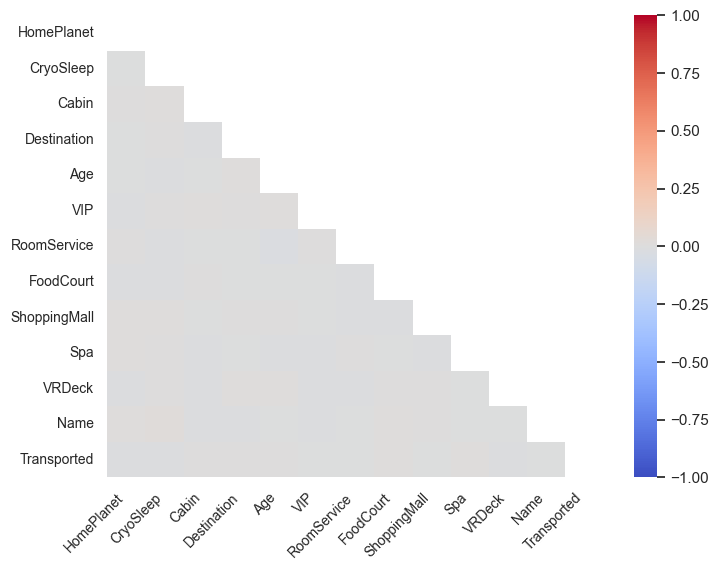

In [6]:
_, ax = plt.subplots(figsize=(8,6))
msno.heatmap(full_df, cmap="coolwarm", fontsize=10, ax=ax)
plt.show();

There seems not to be any patterns here, meaning that missing values in one feature are independent from others in other features.

# Correlations between variables


I'll create the features I've created in the main notebook:

In [7]:
full_df['Group'] = full_df['PassengerId'].str.split('_').str[0]

group_full_df = full_df['Group'].value_counts().reset_index()
group_full_df.columns = ['Group', 'GroupSize']
group_full_df['TravelAlone'] = np.where(group_full_df['GroupSize'] == 1, 1, 0)

full_df = full_df.merge(group_full_df, on='Group', how='left')

In [8]:
full_df['CabinDeck'] = full_df['Cabin'].str.split('/').str[0]
full_df['CabinNumber'] = full_df['Cabin'].str.split('/').str[1]
full_df['CabinSide'] = full_df['Cabin'].str.split('/').str[2]

full_df = full_df.drop(columns='Cabin')

I'm going to drop columns that I won't be using:

In [9]:
full_df = full_df.drop(columns=['PassengerId', 'Name'])

For the correlation matrix I won't use `Group` and `CabinNumber` as they have many different values.

In [10]:
phik_df = full_df.drop(columns=['Group', 'CabinNumber', 'is_train'])

interval columns not set, guessing: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize', 'TravelAlone']


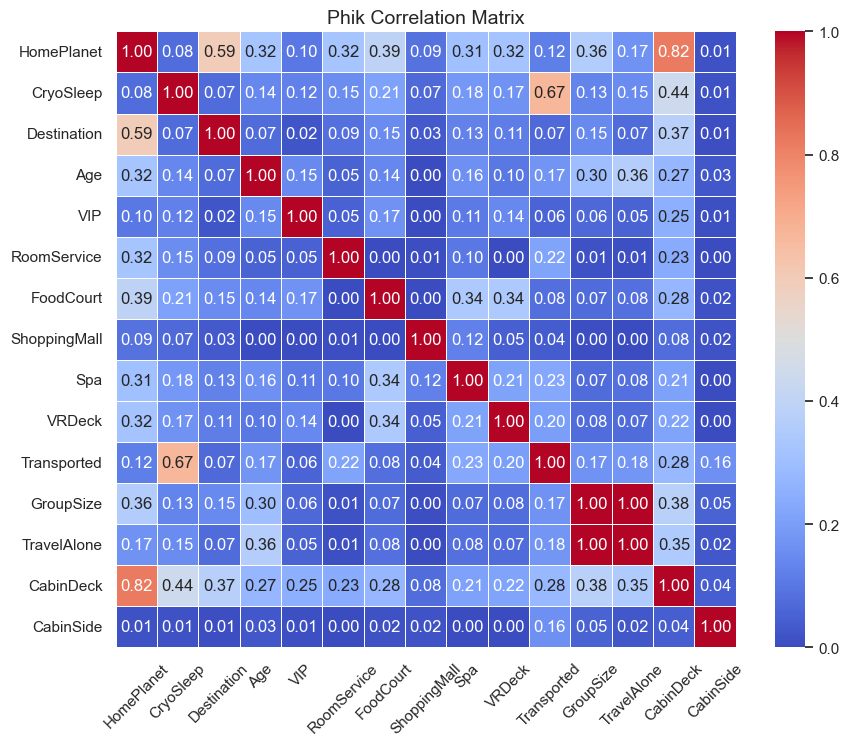

In [11]:
phik_corr = phik_df.phik_matrix()
plt.figure(figsize=(10,8))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

plt.title('Phik Correlation Matrix', fontsize=14)
plt.xticks(rotation=45)
plt.show();

From the correlation matrix, it can be seen that `HomePlanet` is correlated with `CabinDeck` and with `Destination`. `CryoSleep` also correlates with `Cabindeck` but in a much weaker way.

In [12]:
def plot_normalized_percentages(
    df: pd.DataFrame,
    feature1: list,
    feature2: str,
    nrows: int = 1,
    ncols: int = 1,
    figsize: tuple = (10, 6),
    label_format: str = ".0f",
) -> None:
    """
    Plots the normalized percentages of categorical features in `feature1`
    with respect to `feature2` as bar charts.

    The function calculates the percentage distribution of `feature2`
    within each category of `feature1`, then visualizes it using Seaborn's barplot.
    It also annotates the bars with percentage values.

    Args:
        - df (pd.DataFrame): The input dataframe containing the data.
        - feature1 (list): A list of categorical feature names to be plotted.
        - feature2 (str): The categorical feature to be used for grouping in the bar charts.
        - nrows (int, optional): Number of subplot rows. Defaults to 1.
        - ncols (int, optional): Number of subplot columns. Defaults to 1.
        - figsize (tuple, optional): Figure size for the subplots. Defaults to (10,6).
        - label_format (str, optional): Allows to modify the decimal places in the labels on top of the bars.

    Returns:
        None: Displays the bar plots and does not return anything.

    """
    _, ax = plt.subplots(nrows, ncols, figsize=figsize)

    # Ensure ax is always iterable
    ax = np.ravel(ax)

    columns = feature1

    for i, col in enumerate(columns):
        # Compute normalized percentages
        ct = pd.crosstab(df[col], df[feature2], normalize="index")
        ct_long = ct.reset_index().melt(
            id_vars=col, var_name=feature2, value_name="Percentage"
        )
        ct_long["Percentage"] *= 100

        barchart = sns.barplot(
            data=ct_long, x=col, y="Percentage", hue=feature2, ax=ax[i]
        )

        # Add percentages on bars
        for p in barchart.patches:
            if p.get_height() > 0:
                barchart.annotate(
                    text=f"{p.get_height():{label_format}}%",
                    xy=(p.get_x() + p.get_width() / 2, p.get_height() + 0.3),
                    ha="center",
                    fontsize=10,
                )
        ax[i].set_title(f"{col} Normalized Percentage by {feature2}")
        ax[i].set_xlabel(f"{col}")
        ax[i].set_ylabel("Proportion")
        ax[i].tick_params(axis="y", left=False, labelleft=False)

    plt.tight_layout()
    plt.show()
    return None

## HomePlanet

HomePlanet has shown a strong correlation with other variables, so we could use this knowledge to impute its missing values.

I'm also supsecting that passengers travelling in the same group will all come from the same home planet. Let's quickly check this assumption:

In [13]:
temp_df = full_df[['HomePlanet', 'Group']].dropna().drop_duplicates()

grouped_temp_df = temp_df.groupby('Group').agg({'HomePlanet': 'count'}).reset_index()
grouped_temp_df[grouped_temp_df['HomePlanet'] > 1]

,Group,HomePlanet


As I was assuming, passengers in the same group always come from the same planet. So this can be the first rule to apply for imputing null values in this column.

Let's now move to explore the distribution of `HomePlanet` per `CabinDeck` and `Destination`:

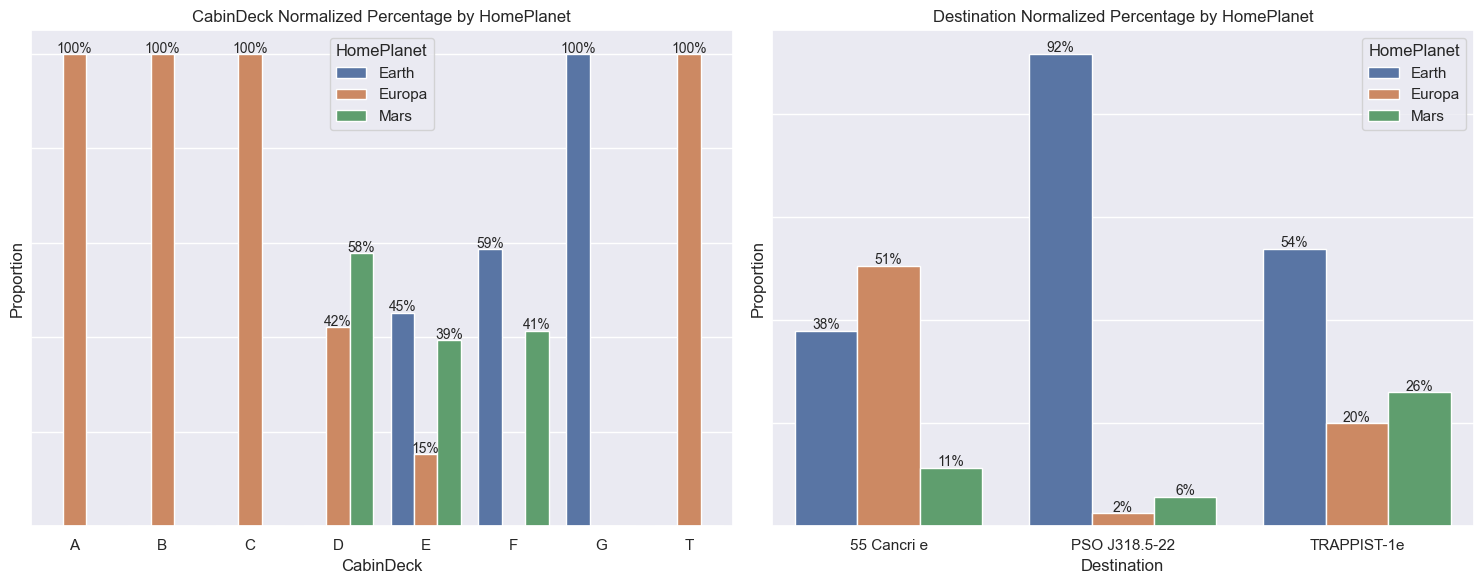

In [14]:
plot_normalized_percentages(full_df, ['CabinDeck', 'Destination'], 'HomePlanet', nrows=1, ncols=2, figsize=(15,6))

The distribution of `HomePlanet` varies between cabin decks and it is also related with the destination. We can use this knowledge to impute missing values for this column. I'm creating a function that will impute missing values following this procedure:
- Create a dummy variable indicating if the planet was missing.
- If a passenger travels in a group, I'll use the information from the group (if available), to impute this value.
- In case the information from the group is not available, I'll use the most frequent value of the `CabinDeck` to impute the `HomePlanet`.
- If that record has also missing information for the `CabinDeck`, I'll use the `Destination`.
- If the value is still missing, I'll impute with the mode.


In [15]:
# First, I'm creating a function to calculate the mode for each category
def mode_by_category(df: pd.DataFrame, cat_feature: str, target: str) -> dict:
    """
    Function that calculates the mode of the target feature for each categorical value of 'cat_feature' to use them for imputation

    Args:
        - df (pd.DataFrame): Input data frame containing original data.
        - cat_feature (str): Categorical feature to group by.
        - target (str): target feature to calculate the mode for each category of 'cat_feature'.

    Returns:
        - dict: A dictionary containing the values of each category of 'cat_feature' as keys and the mode of the target feature as values.
    """
    return df.groupby(cat_feature)[target].apply(lambda x: x.mode().iloc[0]).to_dict()

In [16]:
def impute_homeplanet_nulls(
        df: pd.DataFrame
    ) -> pd.DataFrame:
    """
    Imputes missing values in the 'HomePlanet' column using a heuristic approach.
    It first creates a dummy column flagging null values in 'HomePlanet'.
    Then, it iterates over the missing values and imputes them based on the following heuristics:
        1. If 'Group' is available and it is a key in the 'homeplanet_by_group_dict', use that value.
        2. Else, if 'CabinDeck' is available and it is a key in the 'mode_by_cabindeck', use that value.
        3. Else, if 'Destination' is available and it is a key in the 'mode_by_destination', use that value.
        4. Finally, if all else fails, use the global mode 'mode_value'.

    Args:
        - df (pd.DataFrame): The input DataFrame containing missing values for 'HomePlanet'.

    Returns:
        - pd.DataFrame: The DataFrame with missing 'HomePlanet' values imputed.
    """

    df_copy = df.copy()
    df_copy['HomePlanetMissing'] = df_copy['HomePlanet'].isna().astype(int)

    # Get the homeplanet for each group
    temp_df = df_copy[['Group', 'HomePlanet']].dropna().drop_duplicates()
    homeplanet_by_group_dict = {
        row['Group']: row['HomePlanet'] for _, row in temp_df.iterrows()
    }

    # Get homeplanet modes for each cabin deck, destination and overall mode
    homeplanet_mode_by_cabindeck = mode_by_category(df, 'CabinDeck', 'HomePlanet')
    homeplanet_mode_by_destination = mode_by_category(df, 'Destination', 'HomePlanet')
    homeplanet_mode = df['HomePlanet'].mode().iloc[0]

    # Iterate over rows with missing 'HomePlanet'
    for idx, row in df_copy[df_copy['HomePlanet'].isna()].iterrows():
        # 1. Check if 'Group' is available and find the group's 'HomePlanet'
        if pd.notna(row['Group']) and row['Group'] in homeplanet_by_group_dict and homeplanet_by_group_dict[row['Group']] is not None:
            df_copy.at[idx, 'HomePlanet'] = homeplanet_by_group_dict[row['Group']]
            continue

        # 2. If 'Group' is not available or doesn't provide a value, check 'CabinDeck' mode
        if pd.notna(row['CabinDeck']) and row['CabinDeck'] in homeplanet_mode_by_cabindeck and homeplanet_mode_by_cabindeck[row['CabinDeck']] is not None:
            df_copy.at[idx, 'HomePlanet'] = homeplanet_mode_by_cabindeck[row['CabinDeck']]
            continue

        # 3. If 'CabinDeck' is not available, check 'Destination' mode mode_by_destination
        if pd.notna(row['Destination']) and row['Destination'] in homeplanet_mode_by_destination and homeplanet_mode_by_destination[row['Destination']] is not None:
            df_copy.at[idx, 'HomePlanet'] = homeplanet_mode_by_destination[row['Destination']]
            continue

        # 4. If all else fails, use the global mode
        df_copy.at[idx, 'HomePlanet'] = homeplanet_mode

    return df_copy

In [17]:
print(f"Missing values of 'HomePlanet': {full_df['HomePlanet'].isnull().sum()}")
imputed_df = impute_homeplanet_nulls(full_df)
print(f"Missing values of 'HomePlanet' after imputation: {imputed_df['HomePlanet'].isnull().sum()}")

Missing values of 'HomePlanet': 288
Missing values of 'HomePlanet' after imputation: 0


## CryoSleep

In the main notebook, `CryoSleep` showed the highest correlation with the target variable so we should be careful here. In order not to lose information, I'll create a dummy variable to indicate if this value was missing or not, and then, impute the values using some logic.

Since passengers who were on `CryoSleep` were confined to their cabins, I'm also suspecting that they wouldn't be able to spend any money on any of the services `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa` or `VRDeck`. Let's verify that is the case:

In [18]:
full_df[full_df['CryoSleep'] == True][['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].describe()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4488.0,4472.0,4450.0,4474.0,4490.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


This confirms my hypothesis, being that the case, I'll define a function that:
- Creates a new column indicating if this value was missing.
- For the missing values:
    - If any of the services is available and is greater than 0, I'll assign the value `False`.
    - In case this information is not available or there's no value greater than 0, I'll use the mode within each `CabinDeck`.
    - Finally, if `CabinDeck` is also missing, I'll use the overall mode.

In [19]:
def impute_cryosleep_nulls(df: pd.DataFrame) -> pd.DataFrame:
    """
    Imputes missing values in the 'CryoSleep' column using a heuristic approach.

    Steps:
    1. Create a dummy column 'CryoSleepMissing' indicating missing values.
    2. If any of the columns ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
       has a value greater than 0, set 'CryoSleep' to False.
    3. If all these columns are missing or 0, use the mode of 'CryoSleep' for the corresponding 'CabinDeck'.
    4. If 'CabinDeck' is also missing, use the overall mode of 'CryoSleep'.

    Args:
        - df (pd.DataFrame): The input DataFrame containing missing values for 'CryoSleep'

    Returns:
        - pd.DataFrame: A DataFrame with missing 'CryoSleep' values imputed.
    """

    df_copy = df.copy()

    # Create a dummy column
    df_copy["CryoSleepMissing"] = df_copy["CryoSleep"].isna().astype(int)

    # Get the mode by deck and overall mode
    cryosleep_mode_by_deck = mode_by_category(df, "CabinDeck", "CryoSleep")
    cryosleep_mode = df["CryoSleep"].mode().iloc[0]

    # Impute missing values with "False" whenever the spending on services is greater than 0
    services_columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
    df_copy.loc[
        df_copy["CryoSleep"].isna() & (df_copy[services_columns].gt(0).any(axis=1)),
        "CryoSleep",
    ] = False


    for idx, row in df_copy[df_copy["CryoSleep"].isna()].iterrows():
        if (
            pd.notna(row["CabinDeck"])
            and row["CabinDeck"] in cryosleep_mode_by_deck
            and pd.notna(cryosleep_mode_by_deck[row["CabinDeck"]])
        ):
            df_copy.at[idx, "CryoSleep"] = cryosleep_mode_by_deck[row["CabinDeck"]]
        else:
            df_copy.at[idx, "CryoSleep"] = cryosleep_mode

    return df_copy

In [20]:
print(f"Missing values of 'CryoSleep': {imputed_df['CryoSleep'].isnull().sum()}")
imputed_df = impute_cryosleep_nulls(imputed_df)
print(f"Missing values of 'CryoSleep' after imputation: {imputed_df['CryoSleep'].isnull().sum()}")

Missing values of 'CryoSleep': 310
Missing values of 'CryoSleep' after imputation: 0


## Cabin

For the different cabin values, I would like to see first if there are groups travelling together that have been assigned to the same cabin decks and cabin numbers:

In [21]:
distinct_cabin_decks = full_df.groupby('Group')['CabinDeck'].nunique()
distinct_cabin_decks[distinct_cabin_decks > 1]

Group
0006    2
0017    2
0046    2
0064    2
0067    2
       ..
9220    2
9231    2
9238    2
9266    2
9272    2
Name: CabinDeck, Length: 673, dtype: int64

We have 673 of such cases, so this assumption is not 100% correct, but I'd also know how much this cases represent over the total.

In [22]:
percentage = distinct_cabin_decks[distinct_cabin_decks > 1].shape[0] / \
         full_df[full_df['GroupSize']>1]['Group'].nunique() *100

print(f"{percentage:.2f}%")

31.52%


These represent 31.5% of the total cases, it means that nearly 70% of the passengers that travel within the same group are also assigned in the same cabin deck. This can be used to impute missing values on the `CabinDeck`. 

`CabinNumber` is a column with a lot of different values, so let's see if we can find some way to group the different categories to reduce the cardinality of the column:

In [23]:
full_df['CabinNumber'] = full_df['CabinNumber'].astype(float)

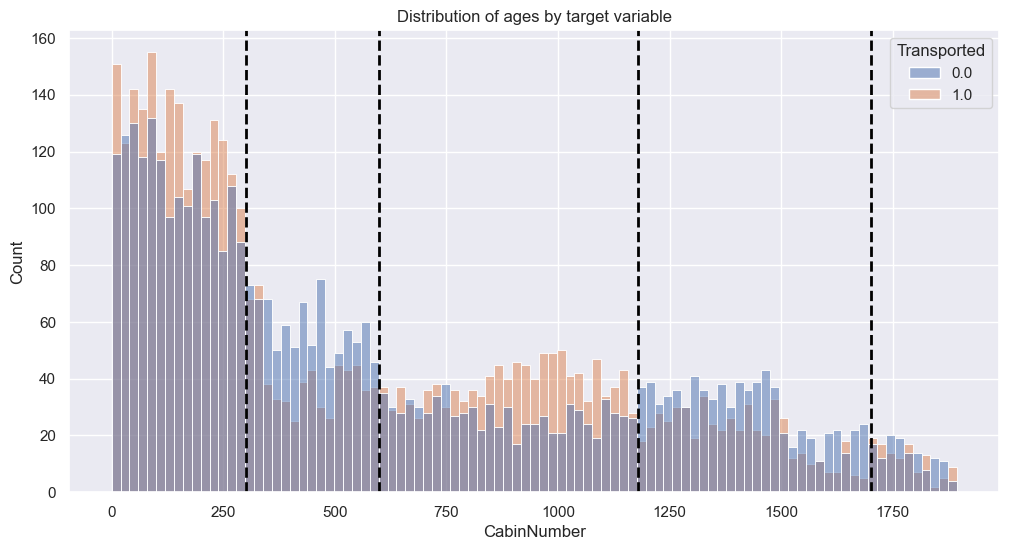

In [24]:
figure = plt.figure(figsize=(12,6))
sns.histplot(
    full_df,
    x='CabinNumber',
    hue='Transported',
    binwidth=20
)
plt.axvline(x=300, color='black', linestyle='--', linewidth=2)
plt.axvline(x=600, color='black', linestyle='--', linewidth=2)
plt.axvline(x=1180, color='black', linestyle='--', linewidth=2)
plt.axvline(x=1700, color='black', linestyle='--', linewidth=2)
plt.title('Distribution of ages by target variable')
plt.show();

In [25]:
full_df['CabinGroup'] = np.where(full_df['CabinNumber']<300, 0,
                               np.where(full_df['CabinNumber']<600, 1,
                                        np.where(full_df['CabinNumber']<1180, 2,
                                                 np.where(full_df['CabinNumber']<1700, 3, 4)
                                                )
                                        )
                                )

full_df['CabinGroup'].value_counts()/full_df[~(full_df['CabinGroup'].isna())].shape[0]

CabinGroup
0    0.405397
2    0.218350
1    0.173246
3    0.152891
4    0.050116
Name: count, dtype: float64

As we can see from the plot, we can identify different trends in regards of the distribution of the target variable:
- The first 300 cabins and cabins between 600 to 1180 were, in general more affected by the transportation.
- The trend then changes affecting less to cabins with numbers greater than 300 and lower than 600, and again cabin numbers between 1180 and 1700. 
- The lasts cabin numbers, those greater than 1700, are more difficult to split.

Because of that I'll use the following approach to impute missing values for `CabinDeck`, `CabinNumber` and `CabinSide`:
- I'm also going to create a dummy variable indicating if the value was missing
- Then I will check if there are more people travelling in the same group, and if so, use their values to impute the missing values in these three columns (we've seen that this is not entirely true, but it will be a better approximation than simply using the mean or mode).
- In case that is not availabe, I will use the mode of the `CabinDeck` for each `HomePlanet`; `CabinNumber` will be grouped into the groups that I've mentioned before, and null values will be imputed following the same distribution that the data presents:
    - Group 0 will have a chance of 40.54% 
    - Group 1 will have a likelihood of 17.32%
    - Group 2 will have a likelihood of 21.83%
    - Group 3 will have a likelihood of 15.29%
    - Group 4 will only have a likelihood of 5.02%
- and `CabinSide` will be picked randomly, as the distribution of the side is uniform across `CabinDecks`.

In [26]:
def impute_cabin_nulls(df: pd.DataFrame) -> pd.DataFrame:
    """
    Imputes missing values in the 'CabinDeck', 'CabinNumber', and 'CabinSide' columns using a heuristic approach.
    Additionally, it assigns 'CabinNumber' into 5 groups and imputes missing values based on a predefined probability distribution.

    Steps:
    1. Create a dummy column 'CabinMissing' (integer) indicating if the cabin information was originally missing.
    2. If the passenger belongs to a group (GroupSize > 1), use the information from other passengers in the group to impute nulls.
    3. If no group information is available or helpful, impute 'CabinDeck' using the most common value for the corresponding 'HomePlanet'.
    4. Assign 'CabinNumber' to a 'CabinNoGroup' based on predefined ranges.
    5. Impute missing 'CabinNoGroup' using a predefined probability distribution.
    6. Impute missing 'CabinSide' randomly as 'P' or 'S'.

    Args:
        - df (pd.DataFrame): The input DataFrame containing 'CabinDeck', 'CabinNumber', 'CabinSide', 'HomePlanet', and 'GroupSize'.

    Returns:
        - pd.DataFrame: A DataFrame with missing cabin values imputed.
    """

    df_copy = df.copy()

    # Create a dummy column indicating missing cabin information
    df_copy["CabinMissing"] = df_copy["CabinDeck"].isna().astype(int)

    # Create a dictionary with the groups as keys and the cabin as values
    group_cabin_dict = {
        row['Group']: {
            'CabinDeck': row['CabinDeck'],
            'CabinNumber': row['CabinNumber'],
            'CabinSide': row['CabinSide']
            }
        for _, row in df_copy.dropna(subset=['CabinDeck']).iterrows()
    }

    # Impute missing cabin values based on other passengers in the same group
    for idx, row in df_copy[df_copy["CabinDeck"].isna()].iterrows():
        if row['Group'] in group_cabin_dict:
            df_copy.at[idx, "CabinDeck"] = group_cabin_dict[row['Group']]['CabinDeck']
            df_copy.at[idx, "CabinNumber"] = group_cabin_dict[row['Group']]['CabinNumber']
            df_copy.at[idx, "CabinSide"] = group_cabin_dict[row['Group']]['CabinSide']

    # Compute mode of 'CabinDeck' for each 'HomePlanet'
    deck_mode_by_homeplanet = df_copy.groupby("HomePlanet")["CabinDeck"].agg(
        lambda x: x.mode()[0] if not x.mode().empty else None
    )

    # Apply mode by 'HomePlanet' where applicable
    for idx, row in df_copy[df_copy["CabinDeck"].isna()].iterrows():
        if (
            pd.notna(row["HomePlanet"])
            and row["HomePlanet"] in deck_mode_by_homeplanet
            and pd.notna(deck_mode_by_homeplanet[row["HomePlanet"]])
        ):
            df_copy.at[idx, "CabinDeck"] = deck_mode_by_homeplanet[row["HomePlanet"]]

    # Assign CabinNoGroup based on CabinNumber
    def assign_cabin_group(number):
        if number < 300:
            return 0
        elif number < 600:
            return 1
        elif number < 1180:
            return 2
        elif number < 1700:
            return 3
        else:
            return 4

    df_copy["CabinNoGroup"] = df_copy["CabinNumber"].astype(float).apply(assign_cabin_group)

    # Step 5: Impute missing 'CabinNoGroup' using predefined probabilities
    missing_cabin_no_group = df_copy["CabinNoGroup"].isna().sum()
    if missing_cabin_no_group > 0:
        # Probabilities for each group
        probabilities = [0.4054, 0.1732, 0.2183, 0.1529, 0.0502]  

        # Randomly assign missing values based on probability distribution
        df_copy.loc[df_copy["CabinNoGroup"].isna(), "CabinNoGroup"] = np.random.choice(
            [0, 1, 2, 3, 4], size=missing_cabin_no_group, p=probabilities
        )

    df_copy.drop(columns='CabinNumber')

    # Step 6: Impute missing 'CabinSide' randomly as 'P' or 'S'
    df_copy.loc[df_copy["CabinSide"].isna(), "CabinSide"] = np.random.choice(
        ["P", "S"], size=df_copy["CabinSide"].isna().sum()
    )

    return df_copy

In [27]:
print(f"Missing values of 'CabinDeck': {imputed_df['CabinDeck'].isnull().sum()}")
imputed_df = impute_cabin_nulls(imputed_df)
print(f"Missing values of 'CabinDeck' after imputation: {imputed_df['CabinDeck'].isnull().sum()}")

Missing values of 'CabinDeck': 299
Missing values of 'CabinDeck' after imputation: 0


## Destination

From the phik correlation matrix, it's been seen that this feature is also correlated with `HomePlanet`. We can use the mode within each home planet to impute missing values here but, again I'd like to apply some logic first. I would like to see how often people from the same group travel to different destinations, if that is not often, I'll first use the information from the same group (if available) to impute missing values; in case that's not available I'll proceed to impute missing values using the mode of each Home planet.

In [28]:
temp_df = full_df[(full_df['GroupSize'] > 1) & ~(full_df.Destination.isna())][['Group', 'Destination']]
grouped_temp_df = temp_df.groupby('Group')['Destination'].nunique().reset_index()
print(f"Number of groups with more than one destination: {grouped_temp_df[grouped_temp_df['Destination'] > 1].shape[0]}")

percentage = grouped_temp_df[grouped_temp_df['Destination'] > 1].shape[0] / \
         full_df[full_df['GroupSize']>1].shape[0] * 100

print(f"Percentage of groups with more than one destination: {percentage:.2f}%")

Number of groups with more than one destination: 1070
Percentage of groups with more than one destination: 18.37%


As we can see, while is not uncommon (there are 1070 groups with more than one destination), it is far from being the rule. Being this the case, I'll follow this approach and try to use the available information from the group and then impute the missing values using the mode of each `HomePlanet`.

In [29]:
def impute_destination_nulls(df: pd.DataFrame) -> pd.DataFrame:
    """
    Imputes missing values in the 'Destination' column using a hierarchical approach.

    Steps:
    1. Create a dummy variable identifying missing values.
    2. If the passenger belongs to a group, use the first known 'Destination' of that group.
    3. If no group information is available or doesn't help, use the mode of 'Destination'
       for the corresponding 'HomePlanet'.
    4. If 'HomePlanet' is also missing, use the overall mode of 'Destination'.

    Args:
        - df (pd.DataFrame): The input DataFrame containing 'Destination', 'Group', and 'HomePlanet'.

    Returns:
        pd.DataFrame: A DataFrame with missing 'Destination' values imputed.
    """

    df_copy = df.copy()
    df_copy["DestinationMissing"] = df_copy["Destination"].isna().astype(int)

    # Get the mode by homeplanet and overall mode
    destination_mode_by_homeplanet = mode_by_category(df, 'HomePlanet', 'Destination')
    destination_mode = df['Destination'].mode().iloc[0]

    # Create a dictionary mapping groups to the first available Destination in the group
    group_destination_dict = (
        df_copy.dropna(subset=['Destination'])
        .groupby('Group')['Destination']
        .first()
        .to_dict()
    )

    # Iterate over rows with missing 'Destination'
    for idx, row in df_copy[df_copy['Destination'].isna()].iterrows():
        # 1. Check if 'Group' is available and has a known 'Destination'
        if pd.notna(row['Group']) and row['Group'] in group_destination_dict:
            df_copy.at[idx, 'Destination'] = group_destination_dict[row['Group']]
            continue  # Move to next row

        # 2. If 'Group' is not available or doesn't help, check 'HomePlanet' mode
        if (
            pd.notna(row['HomePlanet'])
            and row['HomePlanet'] in destination_mode_by_homeplanet
            and pd.notna(destination_mode_by_homeplanet[row['HomePlanet']])
        ):
            df_copy.at[idx, 'Destination'] = destination_mode_by_homeplanet[row['HomePlanet']]
            continue

        # 3. If all else fails, use the global mode
        df_copy.at[idx, 'Destination'] = destination_mode

    return df_copy

In [30]:
print(f"Missing values of 'Destination': {imputed_df['Destination'].isnull().sum()}")
imputed_df = impute_destination_nulls(imputed_df)
print(f"Missing values of 'Destination' after imputation: {imputed_df['Destination'].isnull().sum()}")

Missing values of 'Destination': 274
Missing values of 'Destination' after imputation: 0


## VIP

In the data exploration phase, `VIP` did not show any special correlation with other features, so for this feature I'll just use the mode (no function needed).

## Age

As with `VIP`, the `Age` column does not exhibit any strong correlation with other feature that we could use for imputation. I'll explore it in a bit more detail with respect to the target variable:

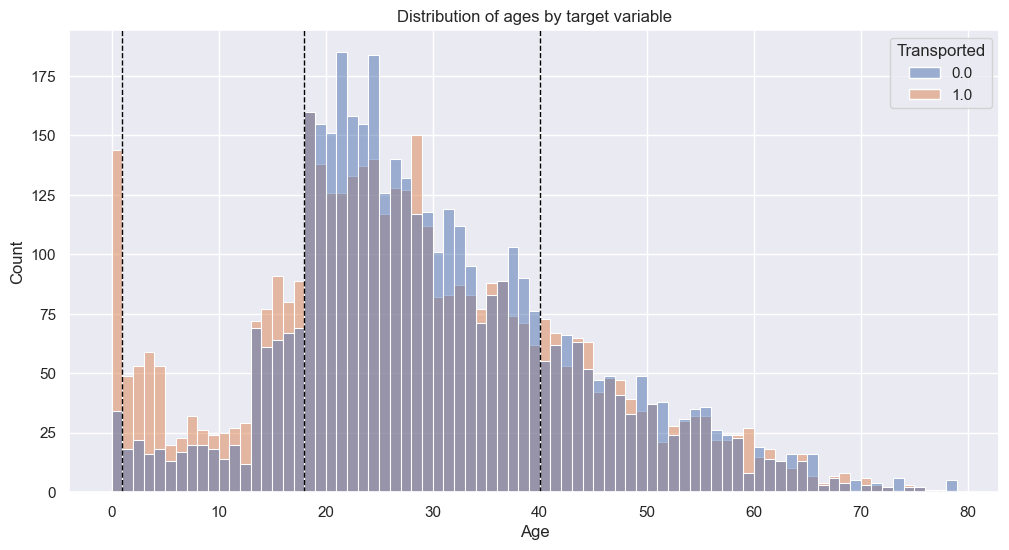

In [31]:
figure = plt.figure(figsize=(12,6))
sns.histplot(
    imputed_df,
    x='Age',
    hue='Transported',
    binwidth=1
)
plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
plt.axvline(x=18, color='black', linestyle='--', linewidth=1)
plt.axvline(x=40, color='black', linestyle='--', linewidth=1)
plt.title('Distribution of ages by target variable')
plt.show();

From the plot it is clear that the transportation affected more to minors, specially those who did not even reach the year. Then, the trend changes, being equal for 18 year old people and being less frequent between ages 19 to 33 (with the exception of people aged 28). According to this, I will impute null values with the mean and then create four groups:
- First group will gather only babies aged 0, as it is clear that they were more affected.
- Second group will contain people aged 1 to 17.
- In the third group there will be people from 18 to 39.
- Lastly the fourth group will contain people 40+.

In [32]:
def impute_age_nulls(df: pd.DataFrame) -> pd.DataFrame:
    """
    Imputes missing values for the 'Age' column with the median value from the input data frame.
    Creates a new column 'AgeMissing' to flag missing values.
    Creates a new column 'AgeGroup' with four groups:
        - 0: Babies (Age == 0)
        - 1: Children/Teens (1 ≤ Age ≤ 17)
        - 2: Young Adults (18 ≤ Age ≤ 40)
        - 3: Adults (34+)

    Args:
        - df (pd.DataFrame): The input data frame with the missing values of 'Age'.

    Returns:
        - pd.DataFrame: A new data frame with missing values imputed and new columns added.
    """

    df_copy = df.copy()
    df_copy['AgeMissing'] = df_copy['Age'].isna().astype(int)

    median_age = df_copy['Age'].median()

    # Impute missing values with the median
    df_copy['Age'] = df_copy['Age'].fillna(median_age)

    # Define age groups
    def age_grouping(age):
        if age == 0:
            return "0"  # Babies
        elif 1 <= age <= 17:
            return "1"  # Children/Teens
        elif 18 <= age <= 39:
            return "2"  # Young Adults
        else:
            return "3"  # Adults

    # Apply the age grouping
    df_copy['AgeGroup'] = df_copy['Age'].apply(age_grouping)

    # Convert to an ordered categorical variable
    age_categories = ["0", "1", "2", "3"]
    df_copy['AgeGroup'] = pd.Categorical(df_copy['AgeGroup'], categories=age_categories, ordered=True)

    # Drop the original 'Age' column    
    df_copy.drop(columns='Age', inplace=True)

    return df_copy

In [33]:
print(f"Missing values of 'Age' before imputation: {imputed_df['Age'].isnull().sum()}")
imputed_df = impute_age_nulls(imputed_df)
print(f"Missing values of 'Age' after imputation: {imputed_df['AgeGroup'].isnull().sum()}")

Missing values of 'Age' before imputation: 270
Missing values of 'Age' after imputation: 0


## Amenities

For the amenities, I will check if the passenger is suspended (`CryoSleep = 1`), if it is, all amenities will be imputed with 0, else I'll use the median.

In [34]:
def impute_amenities_nulls(df: pd.DataFrame, amenity: str) -> pd.DataFrame:
    """
    Imputes missing values for the amenity passed as an argument.
    First it checks if the passenger was on CryoSleep, if so, it imputes a 0. Else, it will use the median

    Args:
        - df (pd.DataFrame): Input data frame containing the amenity column with missing values.
        - amenity (str): The name of the amenity to impute.

    Returns:
        - pd.DataFrame: A new data frame with missing values imputed.
    """

    df_copy = df.copy()

    mode_value = df_copy[amenity].median()
    for idx, row in df_copy[df_copy[amenity].isna()].iterrows():
        if row['CryoSleep']:
            df_copy.at[idx, amenity] = 0
        else:
            df_copy.at[idx, amenity] = mode_value

    return df_copy

In [35]:
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for col in amenities:
    print(f"Missing values of '{col}' before imputation: {imputed_df[col].isnull().sum()}")
    imputed_df = impute_amenities_nulls(imputed_df, col)
    print(f"Missing values of '{col}' after imputation: {imputed_df[col].isnull().sum()}\n\n")

Missing values of 'RoomService' before imputation: 263
Missing values of 'RoomService' after imputation: 0


Missing values of 'FoodCourt' before imputation: 289
Missing values of 'FoodCourt' after imputation: 0


Missing values of 'ShoppingMall' before imputation: 306
Missing values of 'ShoppingMall' after imputation: 0


Missing values of 'Spa' before imputation: 284
Missing values of 'Spa' after imputation: 0


Missing values of 'VRDeck' before imputation: 268
Missing values of 'VRDeck' after imputation: 0




## Cabin Side

`CabinSide` has shown no correlation with any other variable and only a weak correlation with the target (phik correlation factor of just 0.16), but I wonder if it would have any meaning if we combine it with the `CabinDeck`.

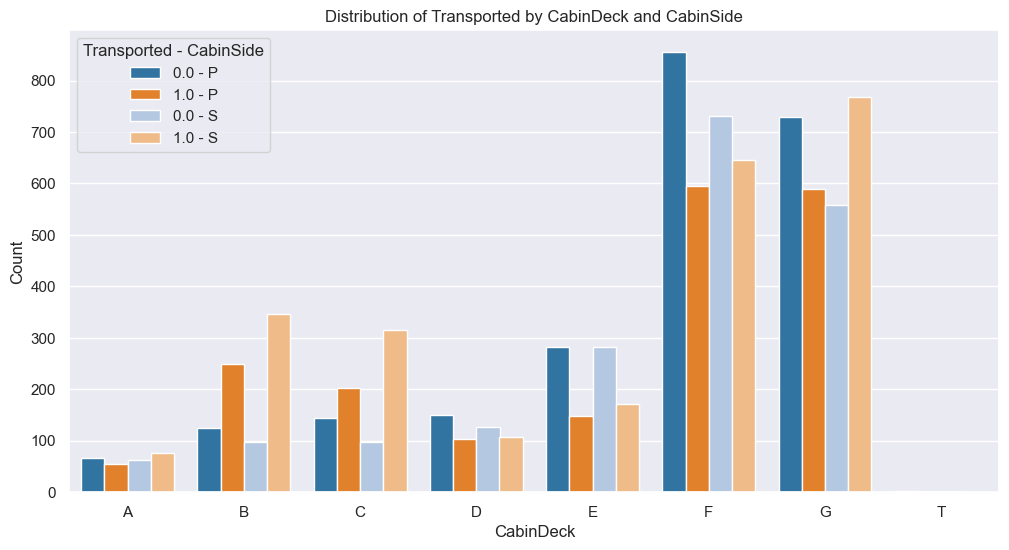

In [36]:
# Define the correct order for the legend
hue_order = ["0.0 - P", "1.0 - P", "0.0 - S", "1.0 - S"]

# Define a custom palette with shades of blue (0) and orange (1)
custom_palette = {
    "0.0 - P": "#1f77b4",  # Dark Blue
    "0.0 - S": "#aec7e8",  # Light Blue
    "1.0 - P": "#ff7f0e",  # Dark Orange
    "1.0 - S": "#ffbb78"   # Light Orange
}

# Filter training data
imputed_train_df = imputed_df[imputed_df['is_train'] == 1]

# Create the plot
plt.figure(figsize=(12, 6))

sns.countplot(
    data=imputed_train_df,
    x="CabinDeck",
    hue=imputed_train_df["Transported"].astype(str) + " - " + imputed_train_df["CabinSide"],  
    dodge=True,  
    order=sorted(imputed_train_df['CabinDeck'].unique()),  
    hue_order=hue_order,  # Ensure correct legend order
    palette=custom_palette  # Apply custom colors
)

plt.title("Distribution of Transported by CabinDeck and CabinSide")
plt.xlabel("CabinDeck")
plt.ylabel("Count")
plt.legend(title="Transported - CabinSide")
plt.xticks(rotation=0)

plt.show()


The general trend is the same for the majority of the decks:
- Decks `B`, `C`, `D`, `E` and `F`: no matter what side of the ship the passenger was if the transportation affected more these passengers, that is also reflected in both sides. In `B` and `C` all passengers were more affected by the transportation, whereas in `D`, `E` and `F` the mmajority were not affected.
- For `A` and `G` the situation is different. Being in the **P** side in these decks decreased the likelihood of being teleported, and the **S** side shows higher chances.

# Outliers

Let's look now at outliers and how they relate with the target variable. For that, I'll work only with the training set.

In [37]:
def identify_outliers(df: pd.DataFrame, column: str, iqr_factor: float = 1.5) -> pd.DataFrame:
    Q1 = np.percentile(df[df[column] > 0][column], 0.25)
    Q3 = np.percentile(df[df[column] > 0][column], 0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + iqr_factor * IQR

    df[f'{column}_outlier'] = (df[column] > upper_bound).astype(int)
    return df

In [38]:
for col in amenities:
    full_df = identify_outliers(full_df, col, 1.5)

In [39]:
full_df.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'is_train',
       'Group', 'GroupSize', 'TravelAlone', 'CabinDeck', 'CabinNumber',
       'CabinSide', 'CabinGroup', 'RoomService_outlier', 'FoodCourt_outlier',
       'ShoppingMall_outlier', 'Spa_outlier', 'VRDeck_outlier'],
      dtype='object')

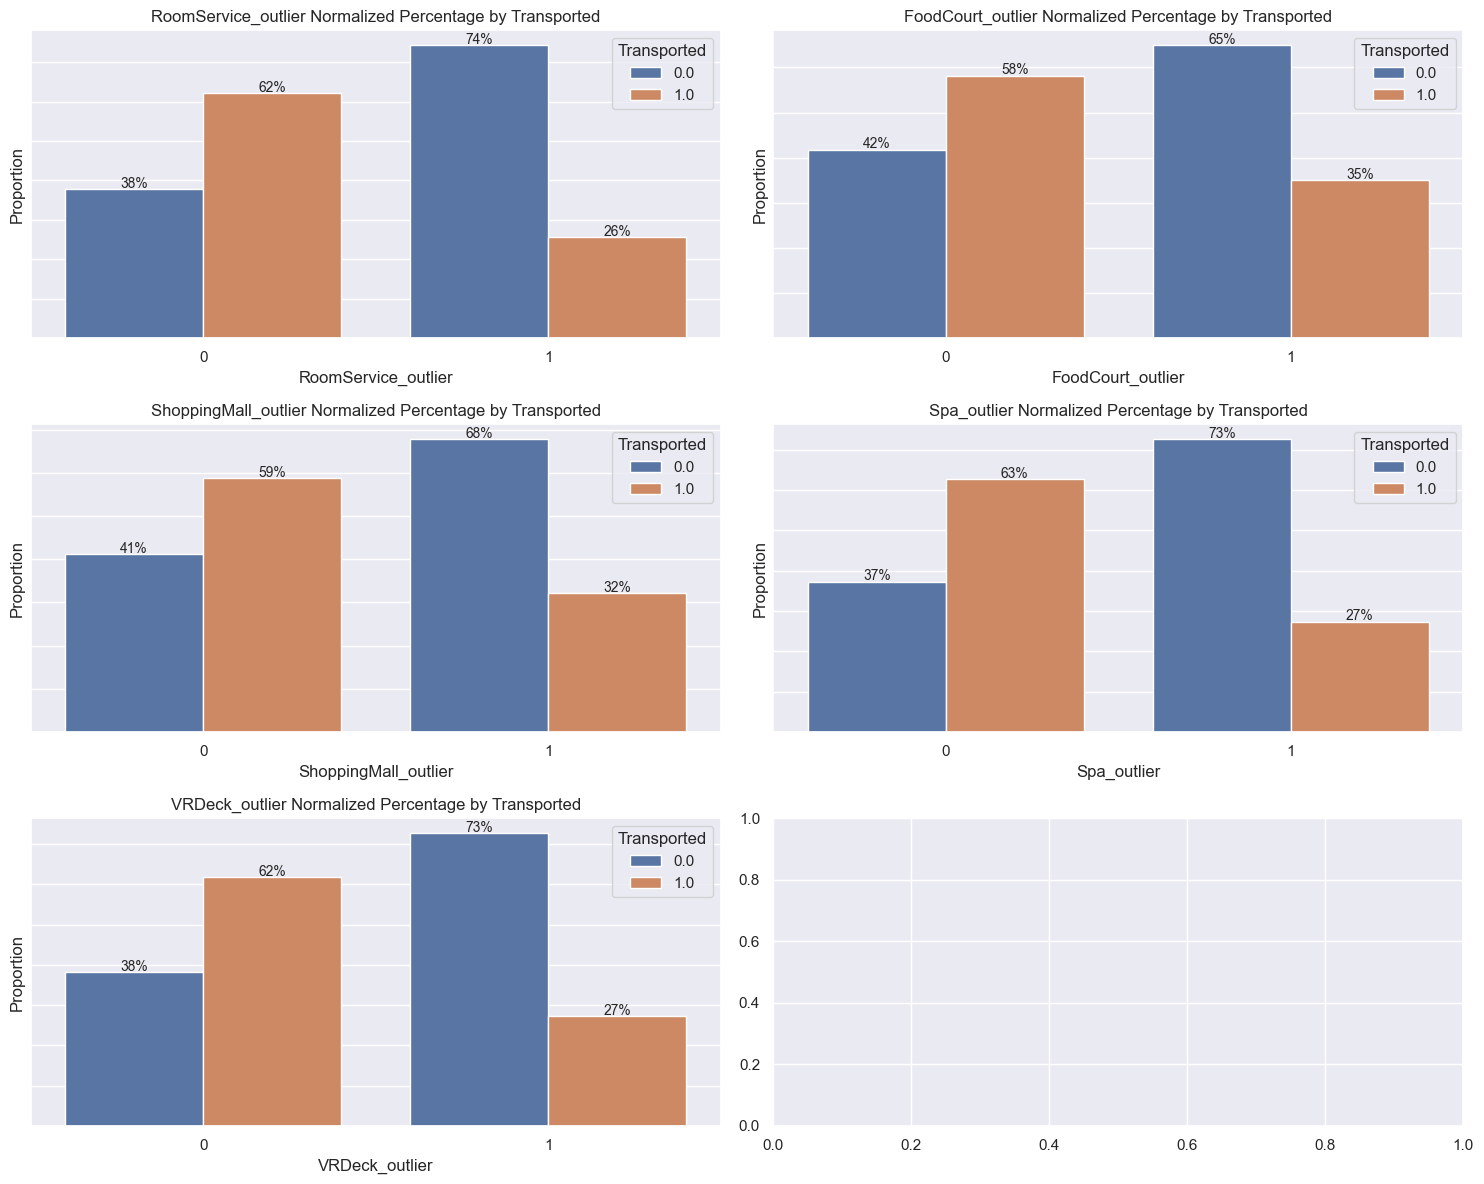

In [40]:
amenities_outliers = [f'{col}_outlier' for col in amenities]

plot_normalized_percentages(full_df, amenities_outliers, 'Transported', nrows=3, ncols=2, figsize=(15, 12))

From the charts above we can identify that outliers carry information related to the target variable as the distribution of transported passengers changes between those who are labeled as outliers and those who aren't. We can investigate if we can further identify different percentages bining the passengers according to their spending habits.

As a first approach, I'll simply split the data into the ones who spent some money and the ones who did not.

In [41]:
for amenity in amenities:
    full_df[f'{amenity}_spender'] = (full_df[amenity] > 0).astype(int)

In [42]:
amenities_spender = [f"{amenity}_spender" for amenity in amenities]

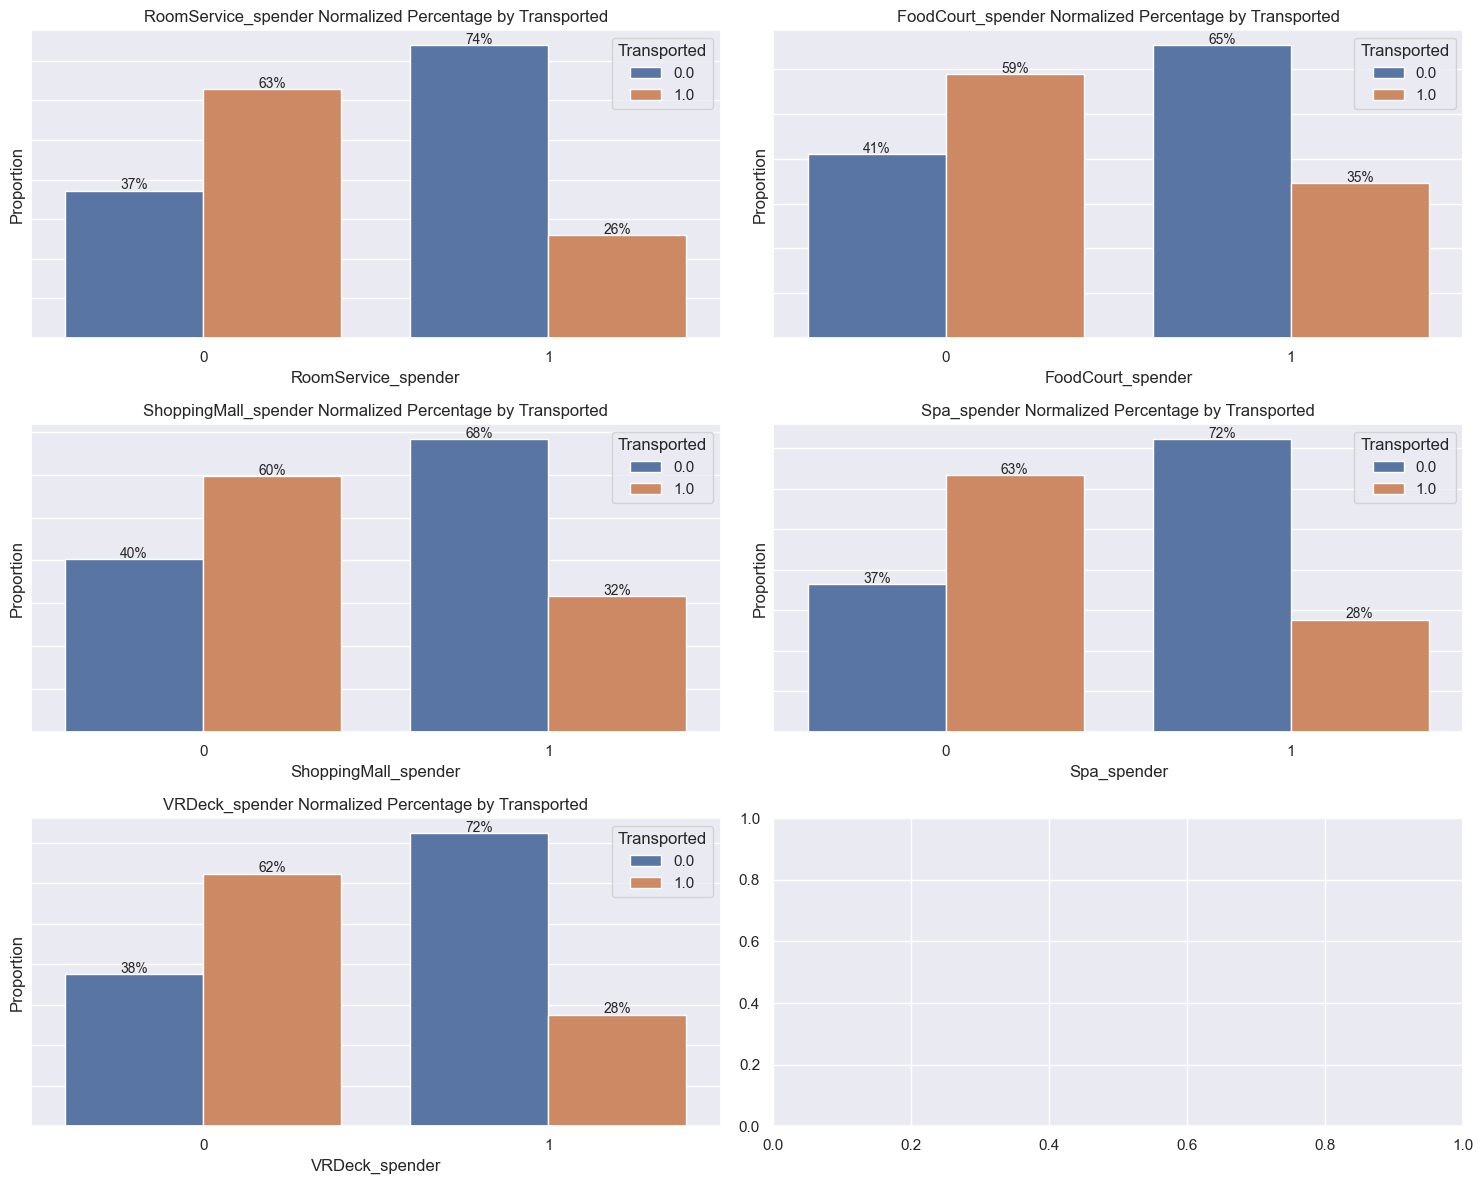

In [43]:
plot_normalized_percentages(full_df, amenities_spender, 'Transported', nrows=3, ncols=2, figsize=(15, 12))

Does spending really affect? Or is it related with the fact that being a non-spender is related with the increased likelihood of being in cryo sleep?

In [44]:
imputed_df['TotalSpent'] = imputed_df[amenities].sum(axis=1)

conditions = [
    (imputed_df['CryoSleep'] == True),  # Condition 1: CryoSleep is "True"
    (imputed_df['CryoSleep'] == False) & (imputed_df['TotalSpent'] == 0),  # Condition 2: Non-Spender
    (imputed_df['CryoSleep'] == False) & (imputed_df['TotalSpent'] > 0),  # Condition 3: Spender
]

# Define corresponding values
choices = ['cryosleep', 'non spender', 'spender']

# Apply classification
imputed_df['spending_status'] = np.select(conditions, choices, default='NA')  

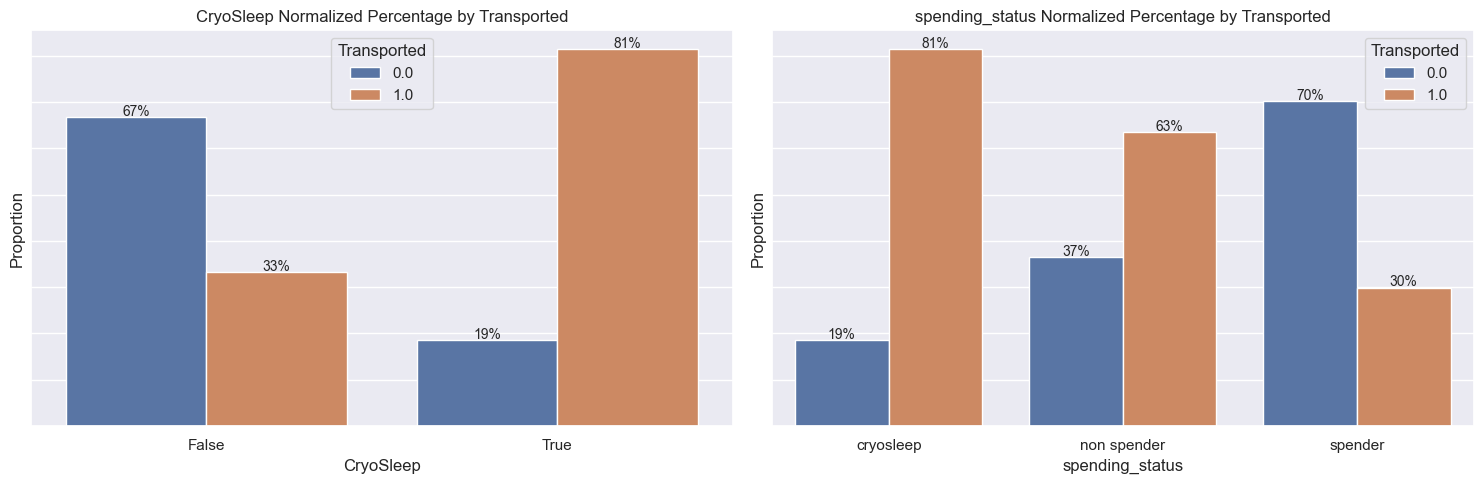

In [45]:
plot_normalized_percentages(imputed_df, ['CryoSleep', 'spending_status'], 'Transported', nrows=1, ncols=2, figsize=(15, 5))

From the above chart, it is clear than more than being an outlier, what actually makes a difference between passengers is spending money on the amenities. The most affected passengers were those ones in cryo sleep, followed by the passengers who did not spend any money and, lastly, the ones who spent money were the least affected.

In [46]:
imputed_df['spending_status'].value_counts()

spending_status
spender        7513
cryosleep      4655
non spender     802
Name: count, dtype: int64

We can also check if the percentage is different if we bin passengers by their spending habits.

In [47]:
p25 = imputed_df[imputed_df['TotalSpent']>0]['TotalSpent'].quantile(0.25)
p75 = imputed_df[imputed_df['TotalSpent']>0]['TotalSpent'].quantile(0.75)
p90 = imputed_df[imputed_df['TotalSpent']>0]['TotalSpent'].quantile(0.9)

In [48]:
conditions = [
    (imputed_df['CryoSleep'] == True),  # Condition 1: CryoSleep is "True"
    (imputed_df['CryoSleep'] == False) & (imputed_df['TotalSpent'] == 0), # Condition 2: Non-Spender
    (imputed_df['CryoSleep'] == False) & (imputed_df['TotalSpent'] > 0) & (imputed_df['TotalSpent'] < p25),  # Condition 3: low spender
    (imputed_df['CryoSleep'] == False) & (imputed_df['TotalSpent'] >= p25) & (imputed_df['TotalSpent'] < p75),  # Condition 4: medium spender
    (imputed_df['CryoSleep'] == False) & (imputed_df['TotalSpent'] >= p75) & (imputed_df['TotalSpent'] < p90),  # Condition 5: high spender
    (imputed_df['CryoSleep'] == False) & (imputed_df['TotalSpent'] >= p90)  # Condition 6: very high spender
]

# Define corresponding values
choices = ['cryosleep', 'non spender', 'low spender', 'medium spender', 'high spender', 'outlier']

# Apply classification
imputed_df['spending_status2'] = np.select(conditions, choices, default='NA')  
imputed_df['spending_status2'] = pd.Categorical(imputed_df['spending_status2'], categories=choices, ordered=True)

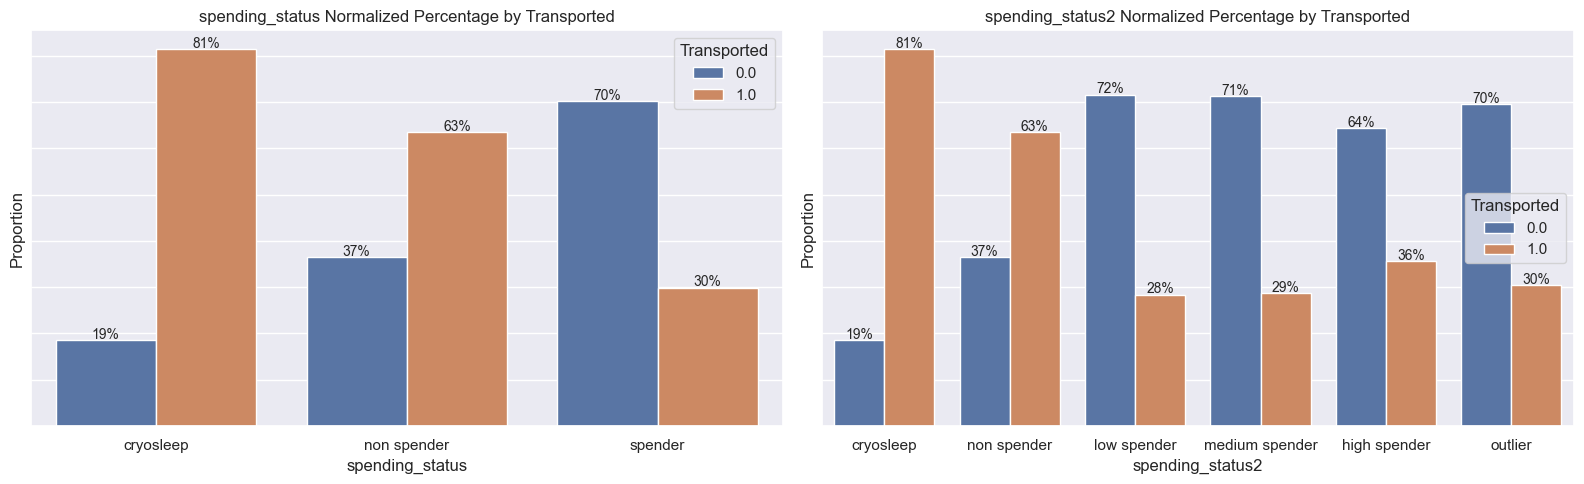

In [49]:
plot_normalized_percentages(imputed_df, ['spending_status', 'spending_status2'], 'Transported', nrows=1, ncols=2, figsize=(16, 5))

As can be seen, the percentages of the different spending levels gravitate around the ones of the general spender levels (70-30), so it won't add any meaningful information to partition the data by them. To verify this, we can run a small test. I will group together the three levels defined before `low`, `medium` and `high` and compare them with the proportions of the `outlier` to see if there's a statistically significant difference.

In [51]:
imputed_df["spending_status2"] = imputed_df["spending_status2"].map(
    lambda x: "spender" if x in ["low spender", "medium spender", "high spender"] else x
)


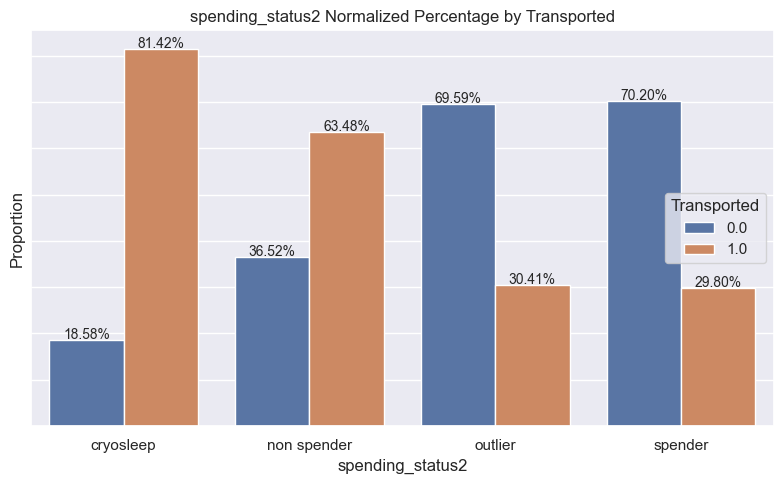

In [53]:
plot_normalized_percentages(imputed_df, ['spending_status2'], 'Transported', figsize=(8, 5), label_format='.2f')

As we can see after grouping, the difference in proportions is really small, but we can still see if it is statistically significant to create another category that differentiates between spenders and outliers or not.

**A/B Test: Spending Status and Transportation Rate**

**Hypothesis Testing**
The hypothesis we'll be handling here are:

- **$H_0$:** $p_{\text{spender}} = p_{\text{outlier}}$ 
  
- **$H_1$:** $p_{\text{spender}} \neq p_{\text{outlier}} $

Where $p$ stands for the proportion of transported passengers.

**Population**
The population consists of passengers categorized by **spending behavior** (`spending_status2`) and their **transportation outcome** (`Transported` = 1 or 0).

- **Group 1:** Spenders  
- **Group 2:** Outliers  
- We are testing whether **the transportation rate is significantly different** between these two groups.

**Statistical Significance**
- We use a **Z-test for two proportions** to compare the transported proportions.
- The test is **two-tailed** since we are testing for **any difference**, not just greater or smaller.
- **Significance Level (α = 0.05)**  
  - If **p-value < 0.05**, we **reject $H_0$** (significant difference).  
  - If **p-value ≥ 0.05**, we **fail to reject $H_0$** (no significant difference detected).  


In [57]:
testing_df = imputed_df[(imputed_df['spending_status2']=='outlier') | (imputed_df['spending_status2']=='spender')][['spending_status2', 'Transported']]
testing_df.dropna(inplace=True)

In [58]:
pd.crosstab(index=testing_df['spending_status2'], columns=testing_df['Transported'])

Transported,0.0,1.0
spending_status2,,
outlier,357,156
spender,3178,1349


In [ ]:
group1 = "spender"        
group2 = "outlier"    

# Get totals and number of "successes" in each group
n1 = testing_df[testing_df["spending_status2"] == group1].shape[0] 
n2 = testing_df[testing_df["spending_status2"] == group2].shape[0] 

successes1 = testing_df[(testing_df["spending_status2"] == group1) & (testing_df["Transported"] == 1)].shape[0]  
successes2 = testing_df[(testing_df["spending_status2"] == group2) & (testing_df["Transported"] == 1)].shape[0]  

# Compute proportions and pooled proportion 
p1 = successes1 / n1
p2 = successes2 / n2
p_pool = (successes1 + successes2) / (n1 + n2)

# Standard Error
se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))

# Compute Z-score
z_score = (p1 - p2) / se

# Compute p-value (two-tailed test)
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

# Print results
print(f"Proportion of Transported in {group1}: {p1:.4f}")
print(f"Proportion of Transported in {group2}: {p2:.4f}")
print(f"Z-score: {z_score:.4f}")
print(f"P-value: {p_value:.4f}")

# Check significance level (alpha = 0.05)
if p_value < 0.05:
    print("🚀 There is a significant difference between the two groups!")
else:
    print("✅ No significant difference between the two groups.")


Proportion of Transported in spender: 0.2980
Proportion of Transported in outlier: 0.3041
Z-score: -0.2863
P-value: 0.7747
✅ No significant difference between the two groups.


This highlights that, more than the actual amount spent, what has an impact on the transportation rate is the fact of spending any money.

# Conclusion

This analysis allowed to stablish some rules to apply different imputation techniques in the data based on the actual correlations that the data shows between the independent features of the dataset.

It also highlighted the fact that more than the quantity spent on any amenity, the differential factor here is the spent itself, the insights point out that having spent some money on amenities decreases the likelihood of being transported.